# CS 105 Team 7 Mini Project Report

[]

[]

1. What data do you have? (Your answer)
2. What would you like to know? (Your answer)
3. Explore, present and analyze the data. (Generate statistics, perform visualizations)
4. Can you state any hypotheses or make predictions? Which tests can you apply to
5. Verify your hypothesis? (Your answer).
6. Test your hypotheses. Draw the conclusions.
7. Draw the overall conclusion



In [1]:
#test 1, lets cook

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('responses.csv')
# print all column names with index
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

0: Timestamp
1: What class are you filling out this survey for? Check all that apply. If none of the listed options apply, select "Other" and enter your class name (for example, CS105).
2: What is your current class standing?
3: Are you a transfer student?
4: What is your major/minor? (If your major is not listed, please write it in "Other..")
5: Rank the following reasons on why you chose CS (CSBA) or DS as your major or minor? [Interest in technology and problem-solving]
6: Rank the following reasons on why you chose CS (CSBA) or DS as your major or minor? [Fascination with data analysis and decision-making]
7: Rank the following reasons on why you chose CS (CSBA) or DS as your major or minor? [Enjoyment of coding, programming, and building applications]
8: Rank the following reasons on why you chose CS (CSBA) or DS as your major or minor? [Strong job prospects and high earning potential]
9: Rank the following reasons on why you chose CS (CSBA) or DS as your major or minor? [Encourag

# question 2 - favorite cuisine vs on-campus food choice

could you write a short introduction of the question favortie cuisine vs on campus restaurant rating and the question ? the structure should be: the data is using -> the description of the data -> what we would like to see

In [3]:
# extract favorite cuisine columns
fav_cuisine = df[[c for c in df.columns if "Please rank the following cuisines by your preference. (1 being dislike, 5 being like)" in c]]
fav_cuisine.columns = fav_cuisine.columns.str.extract(r'\[(.*)\]')[0]
# print(fav_cuisine.columns.tolist())

# convert to numeric
fav_cuisine = fav_cuisine.apply(lambda col: col.astype(str).str.split(' - ').str[0])
fav_cuisine = fav_cuisine.apply(pd.to_numeric, errors='coerce')
fav_cuisine

,Chinese food,Japanese food,Korean food,Indian food,Vietnamese food,American food,Italian food,Mexican food,Mediterranean food,Fusion / Modern mix cuisine,Other Cuisine (please specify in the next question)
0,5,5,3,2,2,2,5,2,2,2,1
1,1,2,3,3,3,4,5,4,4,3,4
2,4,4,3,3,3,5,5,4,3,3,3
3,5,5,4,1,4,1,4,1,1,1,1
4,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...
119,5,4,3,3,3,4,4,5,3,3,3
120,5,5,5,3,5,1,3,1,3,3,1
121,3,2,4,2,2,2,4,2,4,4,2
122,5,5,3,5,5,4,5,5,5,5,5


In [4]:
# extract restaurant rating columns
rest_rating_cols = df[[c for c in df.columns if "Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often)." in c]]
rest_rating_cols.columns = rest_rating_cols.columns.str.extract(r'\[(.*)\]')[0]
# print(rest_rating_cols.columns.tolist()) # test print

# convert to numeric
rest_rating_cols = rest_rating_cols.apply(lambda col: col.astype(str).str.split(' - ').str[0])
rest_rating_cols = rest_rating_cols.apply(pd.to_numeric, errors='coerce')
rest_rating_cols.head() # test print

,Subway,Habit Burger,Panda Express,Chronic Tacos,Hibachi-san,Halal Shack,The Barns,Scotty convenient store,Dining hall (Glasgow and Lothian)
0,1,1,1,1,1,5,1,1,1
1,5,4,4,4,3,3,4,3,3
2,2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,2,1,1,1


In [5]:
# find other cuisine and rating pairs
df3 = df[["Please rank the following cuisines by your preference. (1 being dislike, 5 being like) [Other Cuisine (please specify in the next question)]", "Please list any other cuisines not included."]]
df3 = df3.rename(columns={
   "Please rank the following cuisines by your preference. (1 being dislike, 5 being like) [Other Cuisine (please specify in the next question)]": "other_cuisine_rate",
    "Please list any other cuisines not included.": "cuisine_name"
})
# print(df3["cuisine_name"].unique())

In [6]:
# clean the data
df3_cleaned = df3.replace(['nan','0','NA', 'na', 'Na', 'N/A','N/a',"Couldn't think of any", "n/A", "no","none",
                           "Not sure","I don't know any others", "N/a",'the rest was uncluded','None ', 'No','idk',
                           '̸̧̛̺̹̟̮͇͖̺̹͇͉̪̹͇͇̈́́̒̋͌̄̑̊̍̔͘͝ͅͅ¿̷̨̯̖̯͙̳̙̖̹̱̤͎̱̤̳́͛̈́̈́̈́̒̉͊͛̕͘̚̕͜','I dont know any other not listed','-','Snacks',"Pizza",'chipotle','convenience foods',
                           'Anything','Soul Food'], pd.NA).dropna()
# print(df3_cleaned["cuisine_name"].unique())

# convert to numeric
df3_cleaned['other_cuisine_rate'] = (df3_cleaned['other_cuisine_rate'].astype(str).str.split(' - ').str[0])
df3_cleaned['other_cuisine_rate'] = pd.to_numeric(df3_cleaned['other_cuisine_rate'], errors='coerce')
df3_cleaned

,other_cuisine_rate,cuisine_name
6,1,Salvadorean
8,3,African Food
18,5,Russian and Eastern European dishes
22,3,Middle Eastern
24,3,tai food
30,4,Mongolian
32,3,Thai
36,5,Ethiopian
41,5,Mongolian
46,5,filipino


In [8]:
# Print column names of the full dataset and the combined cuisine dataframe
# print(f"\ndf3_whole columns ({len(df3_whole.columns)}):")
# print(df3_whole.columns.tolist())

# assign the cuisine columns to region groups
cuisine_region_map = {
    'Chinese food': 'Asian', 
    'Japanese food': 'Asian',
    'Korean food': 'Asian',
    'Indian food': 'Asian',
    'Vietnamese food': 'Asian',
    'Thai': 'Asian',
    'Thai food': 'Asian',
    'tai food': 'Asian',
    'Filipino': 'Asian',
    'Filipino food': 'Asian',
    'filipino': 'Asian',
    'Indonesian food': 'Asian',
    'Malaysian Food': 'Asian',
    'Mongolian': 'Asian',
    'Pakistani Food': 'Asian',
    'Sri Lankan': 'Asian',
    'Taiwanese food': 'Asian',
    
    'Italian food': 'European',
    'French food': 'European',
    'Spanish Food': 'European',
    'Eastern European': 'European',
    'Russian and Eastern European dishes': 'European',
    
    'Mexican food': 'Latin American',
    'Salvadorean': 'Latin American', 
    
    'American food': 'North American',
    
    'Mediterranean food': 'Middle Eastern/African',
    'Middle Eastern': 'Middle Eastern/African',
    'Not sure if it counts as mediterranean, but I like food from the Middle East.': 'Middle Eastern/African',
    
    'African Food': 'Middle Eastern/African',
    'Ethiopian': 'Middle Eastern/African',
    'Nigerian, west African ': 'Middle Eastern/African',
    'South African': 'Middle Eastern/African',
    
    'Fusion / Modern mix cuisine': 'Fusion/Other'
}

restaurant_region_map = {
    'Subway': 'European',
    'Habit Burger': 'North American',
    'Panda Express': 'Asian',
    'Chronic Tacos': 'Latin American',
    'Hibachi-san': 'Asian',
    'Halal Shack': 'Middle Eastern/African',
    'The Barns': 'North American',
    'Scotty convenient store': 'North American',
    'Dining hall (Glasgow and Lothian)': 'Fusion/Other'
}
fav_cuisine
# df3_whole

,Chinese food,Japanese food,Korean food,Indian food,Vietnamese food,American food,Italian food,Mexican food,Mediterranean food,Fusion / Modern mix cuisine,Other Cuisine (please specify in the next question)
0,5,5,3,2,2,2,5,2,2,2,1
1,1,2,3,3,3,4,5,4,4,3,4
2,4,4,3,3,3,5,5,4,3,3,3
3,5,5,4,1,4,1,4,1,1,1,1
4,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...
119,5,4,3,3,3,4,4,5,3,3,3
120,5,5,5,3,5,1,3,1,3,3,1
121,3,2,4,2,2,2,4,2,4,4,2
122,5,5,3,5,5,4,5,5,5,5,5


In [9]:
# --- 1️⃣ Clean column names (for consistency)
fav_cuisine.columns = fav_cuisine.columns.str.strip().str.lower()
rest_rating_cols.columns = rest_rating_cols.columns.str.strip().str.lower()

# --- 2️⃣ Normalize mapping keys
cuisine_region_map = {k.lower().strip(): v for k, v in cuisine_region_map.items()}
restaurant_region_map = {k.lower().strip(): v for k, v in restaurant_region_map.items()}

# --- 3️⃣ Group cuisines by region
fav_cuisine_by_region = pd.DataFrame(index=fav_cuisine.index)

for region in sorted(set(cuisine_region_map.values())):
    # find all cuisine columns belonging to this region that exist in dataframe
    region_cols = [c for c, r in cuisine_region_map.items() if r == region and c in fav_cuisine.columns]
    if region_cols:
        # calculate mean rating across those cuisines for each participant
        fav_cuisine_by_region[region] = fav_cuisine[region_cols].mean(axis=1, skipna=True)
    else:
        # if no columns found, fill with NaN (keeps row count intact)
        fav_cuisine_by_region[region] = pd.NA

# --- 4️⃣ Group restaurants by region
rest_rating_by_region = pd.DataFrame(index=rest_rating_cols.index)

for region in sorted(set(restaurant_region_map.values())):
    region_cols = [r for r, reg in restaurant_region_map.items() if reg == region and r in rest_rating_cols.columns]
    if region_cols:
        rest_rating_by_region[region] = rest_rating_cols[region_cols].mean(axis=1, skipna=True)
    else:
        rest_rating_by_region[region] = pd.NA

# --- 5️⃣ Check shapes to confirm all rows preserved
print("Cuisine regions table shape:", fav_cuisine_by_region.shape)
print("Restaurant regions table shape:", rest_rating_by_region.shape)

# --- 6️⃣ Preview a few rows
print("\nCuisine regions table (first 5 participants):")
print(fav_cuisine_by_region)

print("\nRestaurant regions table (first 5 participants):")
print(rest_rating_by_region)


Cuisine regions table shape: (124, 6)
Restaurant regions table shape: (124, 6)

Cuisine regions table (first 5 participants):
     Asian  European  Fusion/Other  Latin American  Middle Eastern/African  \
0      3.4       5.0           2.0             2.0                     2.0   
1      2.4       5.0           3.0             4.0                     4.0   
2      3.4       5.0           3.0             4.0                     3.0   
3      3.8       4.0           1.0             1.0                     1.0   
4      5.0       5.0           5.0             5.0                     5.0   
..     ...       ...           ...             ...                     ...   
119    3.6       4.0           3.0             5.0                     3.0   
120    4.6       3.0           3.0             1.0                     3.0   
121    2.6       4.0           4.0             2.0                     4.0   
122    4.6       5.0           5.0             5.0                     5.0   
123    3.4      

In [10]:
# Make sure the two dataframes share the same participants
common_index = fav_cuisine_by_region.index.intersection(rest_rating_by_region.index)
fav_cuisine_by_region = fav_cuisine_by_region.loc[common_index]
rest_rating_by_region = rest_rating_by_region.loc[common_index]

# ------------------------------
# 1️⃣ Normalize per participant (row-wise z-score)
# ------------------------------
def row_zscore(df):
    """Normalize each participant’s ratings (row) by their mean and std."""
    return df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)

fav_norm = row_zscore(fav_cuisine_by_region)
rest_norm = row_zscore(rest_rating_by_region)

# ------------------------------
# 2️⃣ Compute heatmap data
# ------------------------------
# Here we compare average normalized ratings by region
heatmap_data = pd.DataFrame(
    index=fav_norm.columns,
    columns=rest_norm.columns,
    data=[
        [
            np.mean(fav_norm[cuisine]) + np.mean(rest_norm[restaurant])
            for restaurant in rest_norm.columns
        ]
        for cuisine in fav_norm.columns
    ]
)

# Normalize to mean-centered scale for better contrast
heatmap_data = heatmap_data - heatmap_data.mean().mean()

region_order = [
    "Asian",
    "European",
    "North American",
    "Latin American",
    "Middle Eastern/African",
    "Fusion/Other"
]
heatmap_ordered = heatmap_data.loc[
    [r for r in region_order if r in heatmap_data.index],
    [c for c in region_order if c in heatmap_data.columns]
]


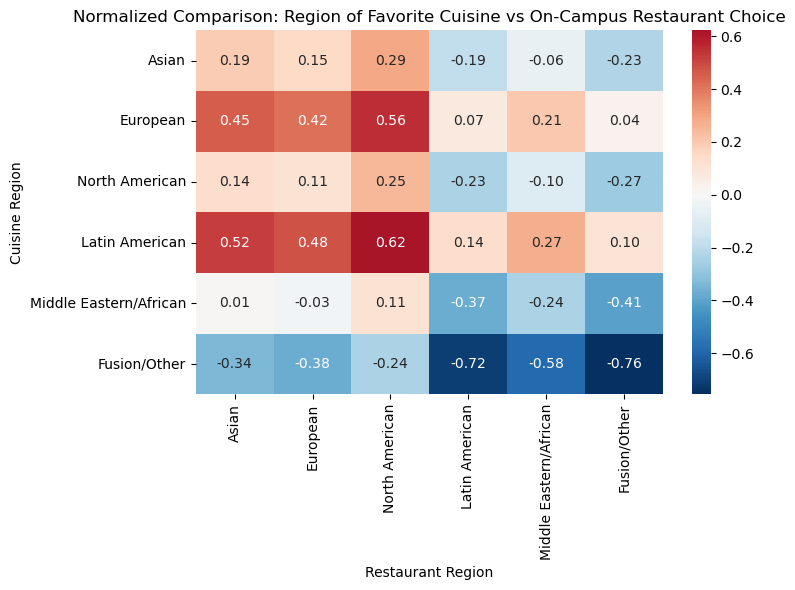

In [18]:

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_ordered, annot=True, cmap="RdBu_r", center=0, fmt=".2f")
plt.title("Normalized Comparison: Region of Favorite Cuisine vs On-Campus Restaurant Choice")
plt.xlabel("Restaurant Region")
plt.ylabel("Cuisine Region")
plt.tight_layout()
plt.show()

# question 3 Imposter Syndrome vs Diff Variables

In [14]:
is_col = 'The National Library of Medicine defines imposter syndrome as, " a behavioral health phenomenon described as self-doubt of intellect, skills, or accomplishments among high-achieving individuals" ("Imposter Phenomenon", 2023). Based on this definition please rate your level of imposter syndrome through your journey in your major. '
seat_col = 'From the front of the class (ranked 1) to the back of the class (ranked 5), where do you sit on average for lecture?'
mental_health_col = 'Rate your overall mental health.'
caff_col = 'How many milligrams of caffeine do you consume per day, on average? For example, a cup of coffee is 95 mg, a shot of espresso is 64mg, a can of Celsius is 200 mg, and a  can of Coca Cola is 34 mg. Answer with a number only.'
is_order = ['1', '2', '3', '4', '5']

### overal mental health vs IS

/var/folders/_2/3lrnsn7x5615sf09xw7cfcfm0000gn/T/ipykernel_77785/1729461184.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


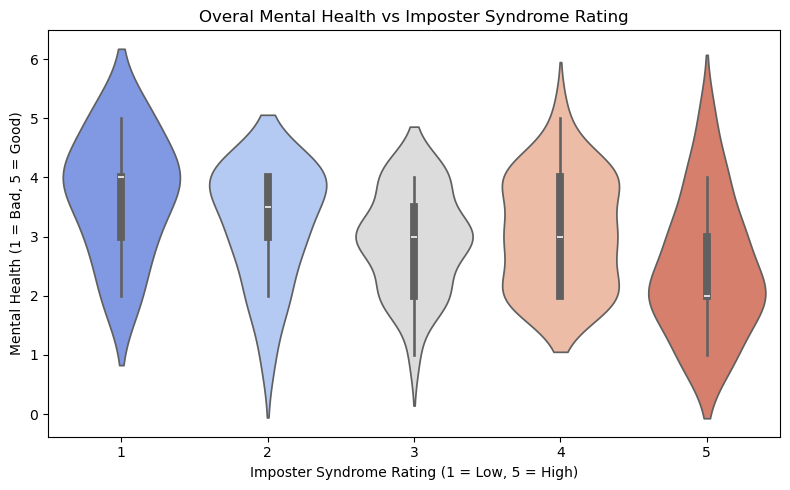

In [15]:
# Select relevant columns and drop missing values
df_plot = df[[is_col, mental_health_col]].dropna()

# Convert IS to integer (if stored as float)
df_plot[is_col] = df_plot[is_col].astype(int)

# Violin plot — one violin per IS rating (1–5)
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_plot,
    x=is_col,
    y=mental_health_col,
    palette="coolwarm",
    inner="box"
)
# sns.stripplot(
#     data=df_plot,
#     x=is_col,
#     y=mental_health_col,
#     color='k',
#     alpha=0.5,
#     jitter=True,
#     size=3
# )
plt.title("Overal Mental Health vs Imposter Syndrome Rating")
plt.xlabel("Imposter Syndrome Rating (1 = Low, 5 = High)")
plt.ylabel("Mental Health (1 = Bad, 5 = Good)") # need the scale info, 1=bad or good?
plt.tight_layout()
plt.show()

### caffiene intake vs IS

/var/folders/_2/3lrnsn7x5615sf09xw7cfcfm0000gn/T/ipykernel_77785/1771480343.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


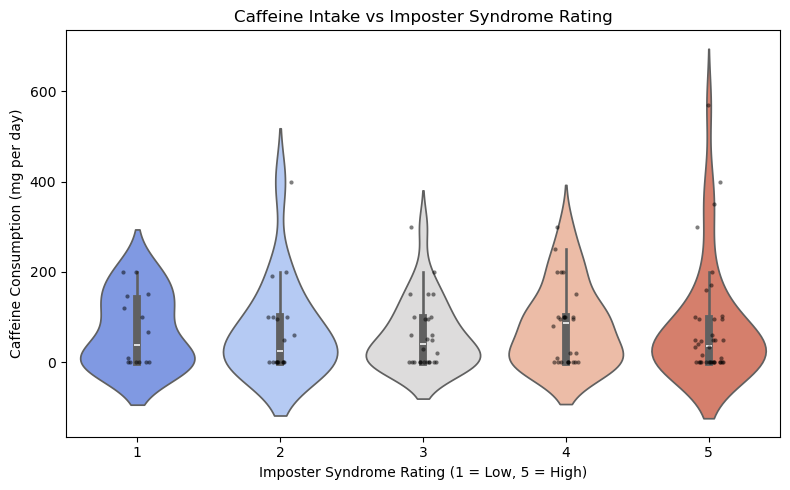

In [16]:
caff_col_clean = 'caffeine_mg'  # new numeric column

# Clean the caffeine data
# Copy column and strip spaces
caff = df[caff_col].astype(str).str.strip().copy()

# Cleaning function
def clean_caffeine(x):
    if pd.isna(x) or x.lower() in ['n/a', 'na']:
        return np.nan
    # Case 1: contains 'mg'
    if 'mg' in x.lower():
        try:
            return float(x.lower().replace('mg','').strip())
        except:
            return np.nan
    # Case 2: range like "95-300"
    if '-' in x:
        try:
            parts = x.split('-')
            nums = [float(p.strip()) for p in parts]
            return np.mean(nums)  # take the average of the range
        except:
            return np.nan
    # Case 3: just a number
    try:
        return float(x)
    except:
        return np.nan

# Apply cleaning
df[caff_col_clean] = caff.apply(clean_caffeine)

# Optional: inspect cleaned data
# print(df[caff_col_clean].describe())
# print(np.sort(df[caff_col_clean].dropna().unique()))

# ------------------------------
# 3️⃣ Prepare data for plotting
# ------------------------------
df_plot = df[[is_col, caff_col_clean]].dropna().copy()
df_plot[is_col] = df_plot[is_col].astype(int).astype(str)  # treat IS rating as categorical

# ------------------------------
# 4️⃣ Create violin plot
# ------------------------------
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_plot,
    x=is_col,
    y=caff_col_clean,
    palette="coolwarm",
    inner="box",
    order=is_order 
)

# Optional: add individual participant points
sns.stripplot(
    data=df_plot,
    x=is_col,
    y=caff_col_clean,
    color='k',
    alpha=0.5,
    jitter=True,
    size=3
)

# Labels and title
plt.title("Caffeine Intake vs Imposter Syndrome Rating")
plt.xlabel("Imposter Syndrome Rating (1 = Low, 5 = High)")
plt.ylabel("Caffeine Consumption (mg per day)")
plt.tight_layout()
plt.show()
